<a href="https://colab.research.google.com/github/Mutum/Mutum-computer_vision_EVA/blob/main/S4/S4_Assignment_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Objective** : Aim is to acheive 98-99 accuracy with less parameters. Here we reduced the number of parameters to **5,850**. In this notebook, we are refining the architecture with reference to [Kaggle Notebook](https://www.kaggle.com/enwei26/mnist-digits-pytorch-cnn-99)

Ideas implemented:
- Reducing the number output channels in conv block. Intuition behind using 10 channels is to represent each digits by one channels.
- Removing Bias from the network to reduce parameters
- Add transition block - Max pooling followed by 1*1 
- Add Batch normalization

In [8]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.optim.lr_scheduler import StepLR,OneCycleLR

%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3, padding=1, bias=False),  #Input:28x28 Output:26x26 GRF:3x3
            nn.BatchNorm2d(10),
            nn.ReLU(),

            nn.Conv2d(10, 10, 3, padding=1, bias=False), #Input:26x26 Output:24x24 GRF:5x5
            nn.BatchNorm2d(10),
            nn.ReLU()    
        )

        self.trans1 = nn.Sequential(
            nn.MaxPool2d(2, 2),  #Input:22x22 Output:11x11 GRF:14x14
            nn.Conv2d(10, 10, 1, bias=False), #Input:22x22 Output:11x11 GRF:14x14
            nn.BatchNorm2d(10),
            nn.ReLU()
        )

        self.conv2 =  nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=1, bias=False), #Input:11x11 Output:9x9 GRF:16x16
            nn.BatchNorm2d(10),
            nn.ReLU(),

            nn.Conv2d(10, 10, 3, padding=1, bias=False),  #Input:9x9 Output:7x7 GRF:18x18
            nn.BatchNorm2d(10),
            nn.ReLU()            
        )

        self.trans2 = nn.Sequential(
            nn.MaxPool2d(2, 2),  #Input:22x22 Output:11x11 GRF:14x14
            nn.Conv2d(10, 10, 1, bias=False), #Input:9x9 Output:7x7 GRF:18x18
            nn.BatchNorm2d(10),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(10, 10, 3, bias=False), #Input:7x7 Output:5x5 GRF:20x20
            nn.BatchNorm2d(10),
            nn.ReLU(),

            nn.Conv2d(10, 10, 3, bias=False), #Input:5x5 Output:3x3 GRF:22x22
            nn.BatchNorm2d(10),
            nn.ReLU(),

            nn.Conv2d(10, 10, 3, bias=False) #Input:5x5 Output:3x3 GRF:22x22
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)

        x = x.view(-1,10)
        return F.log_softmax(x,dim=1)

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
            Conv2d-4           [-1, 10, 28, 28]             900
       BatchNorm2d-5           [-1, 10, 28, 28]              20
              ReLU-6           [-1, 10, 28, 28]               0
         MaxPool2d-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             100
       BatchNorm2d-9           [-1, 10, 14, 14]              20
             ReLU-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 10, 14, 14]             900
      BatchNorm2d-12           [-1, 10, 14, 14]              20
    

In [11]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, **kwargs)

In [12]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss=0
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()


        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        pbar.set_description(desc= f'epoch={epoch} Loss={loss.item()} batch_id={batch_idx:05d}')


    train_loss = epoch_loss / len(train_loader.dataset)
    train_acc=100.*correct/len(train_loader.dataset)
    return train_loss,train_acc


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc=100. * correct / len(test_loader.dataset)
    return test_loss,test_acc

In [14]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.7)

train_loss_values = []
test_loss_values = []
train_accuracy=[]
test_accuracy=[]


for epoch in range(1, 20):
    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss,test_acc = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

epoch=1 Loss=0.10399410873651505 batch_id=00468: 100%|██████████| 469/469 [00:22<00:00, 20.98it/s]


Test set: Average loss: 0.0729, Accuracy: 9795/10000 (97.95%)



epoch=2 Loss=0.02757311426103115 batch_id=00468: 100%|██████████| 469/469 [00:22<00:00, 20.64it/s]


Test set: Average loss: 0.0554, Accuracy: 9816/10000 (98.16%)



epoch=3 Loss=0.040557343512773514 batch_id=00468: 100%|██████████| 469/469 [00:22<00:00, 21.22it/s]


Test set: Average loss: 0.0480, Accuracy: 9847/10000 (98.47%)



epoch=4 Loss=0.020351147279143333 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]


Test set: Average loss: 0.0438, Accuracy: 9857/10000 (98.57%)



epoch=5 Loss=0.025274403393268585 batch_id=00468: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


Test set: Average loss: 0.0393, Accuracy: 9872/10000 (98.72%)



epoch=6 Loss=0.021971091628074646 batch_id=00468: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]


Test set: Average loss: 0.0383, Accuracy: 9878/10000 (98.78%)



epoch=7 Loss=0.01498644519597292 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]


Test set: Average loss: 0.0459, Accuracy: 9858/10000 (98.58%)



epoch=8 Loss=0.09274668246507645 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]


Test set: Average loss: 0.0322, Accuracy: 9895/10000 (98.95%)



epoch=9 Loss=0.06995870918035507 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]


Test set: Average loss: 0.0324, Accuracy: 9897/10000 (98.97%)



epoch=10 Loss=0.05770690366625786 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]


Test set: Average loss: 0.0326, Accuracy: 9900/10000 (99.00%)



epoch=11 Loss=0.04096147045493126 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]


Test set: Average loss: 0.0292, Accuracy: 9902/10000 (99.02%)



epoch=12 Loss=0.035513609647750854 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]


Test set: Average loss: 0.0263, Accuracy: 9916/10000 (99.16%)



epoch=13 Loss=0.01344356406480074 batch_id=00468: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]


Test set: Average loss: 0.0297, Accuracy: 9896/10000 (98.96%)



epoch=14 Loss=0.007912804372608662 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]


Test set: Average loss: 0.0298, Accuracy: 9902/10000 (99.02%)



epoch=15 Loss=0.05655677616596222 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]


Test set: Average loss: 0.0263, Accuracy: 9914/10000 (99.14%)



epoch=16 Loss=0.016426850110292435 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]


Test set: Average loss: 0.0286, Accuracy: 9913/10000 (99.13%)



epoch=17 Loss=0.036421921104192734 batch_id=00468: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]


Test set: Average loss: 0.0256, Accuracy: 9913/10000 (99.13%)



epoch=18 Loss=0.03774150088429451 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.42it/s]


Test set: Average loss: 0.0262, Accuracy: 9913/10000 (99.13%)



epoch=19 Loss=0.0114607447758317 batch_id=00468: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]


Test set: Average loss: 0.0296, Accuracy: 9910/10000 (99.10%)



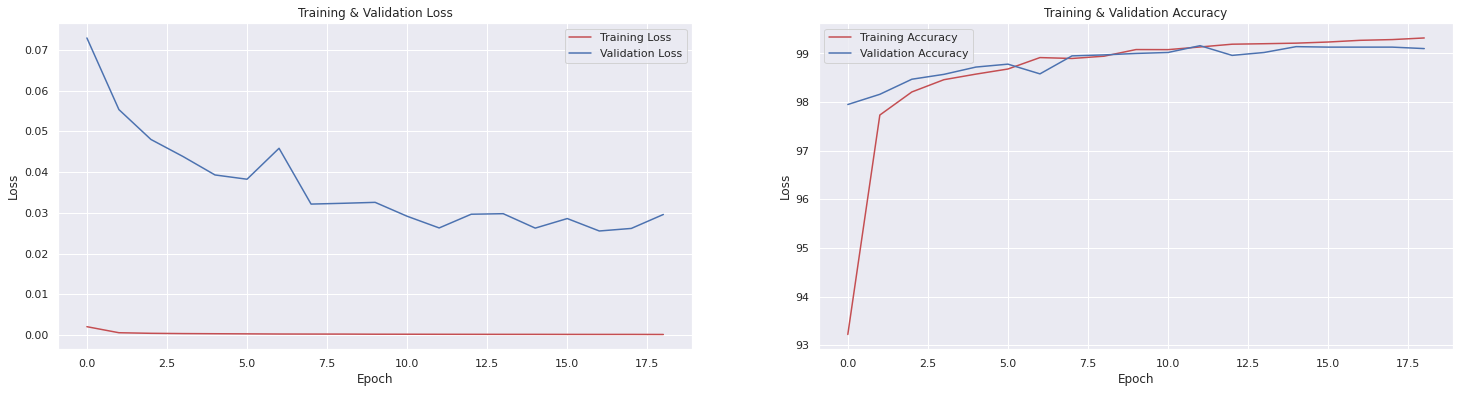

In [15]:

import numpy as np
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (25,6)

# Plot the learning curve.
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(np.array(train_loss_values), 'r', label="Training Loss")
ax1.plot(np.array(test_loss_values), 'b', label="Validation Loss")

# Label the plot.
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(np.array(train_accuracy), 'r', label="Training Accuracy")
ax2.plot(np.array(test_accuracy), 'b', label="Validation Accuracy")

# Label the plot.
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.show()